# 11 | Fundamental Matrix
**ES143 Computer Vision, Harvard University, Fall 2020**

This is an independent coding task. In it you will learn to:
* estimate a fundamental matrix
* use visualization to assess the accuracy of a fundamental matrix

This notebook requires the datafiles `playroom_es143_small.zip`, which is available on the course website.

---

## Instructions

1. Run the notebook.
2. Edit the notebook according to the instructions in Question 1 and Question 2, posting images to [padlet](https://padlet.com/zickler/epipolar) as instructed.
3. Submit .ipynb and .html versions of this notebook to [canvas](https://canvas.harvard.edu/courses/78234/assignments/425054). Submission filenames should be of the form epipolar_lastname_firstname.ipynb and epipolar_lastname_firstname.html.


#### Required packages

In [1]:
# Import required libraries here
import cv2                               # OpenCV
import numpy as np                       # numpy
import requests
import pickle

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters or use plt.figure(figsize=[H, W]) before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

Matplotlib is building the font cache; this may take a moment.


#### Specification of required data files

In [2]:
# Unzip the required datafile if necessary
! unzip -n ./playroom_lowres.zip

# Pickle file with intrinsic calibration: calMatrix ($K$) and distCoeffs
CALIBFILE = './playroom_lowres/playroom_es143_small_calib.pickle'

# Pickle file with AprilBoard geometry: at_finboard and at_coareboard
BOARDFILE = './playroom_lowres/AprilBoards.pickle'

# Two particular images from the playroom dataset for this notebook
LEFTIMAGE = './playroom_lowres/playroom_es143_small_00003.JPG'
RIGHTIMAGE = './playroom_lowres/playroom_es143_small_00004.JPG'


Archive:  ./playroom_lowres.zip
   creating: playroom_lowres/
   creating: playroom_lowres/calib/
  inflating: playroom_lowres/calib/.DS_Store  
   creating: __MACOSX/playroom_lowres/
   creating: __MACOSX/playroom_lowres/calib/
  inflating: __MACOSX/playroom_lowres/calib/._.DS_Store  
  inflating: playroom_lowres/calib/playroom_es143_small_calib_00027.JPG  
  inflating: __MACOSX/playroom_lowres/calib/._playroom_es143_small_calib_00027.JPG  
  inflating: playroom_lowres/calib/playroom_es143_small_calib_00026.JPG  
  inflating: __MACOSX/playroom_lowres/calib/._playroom_es143_small_calib_00026.JPG  
  inflating: playroom_lowres/calib/playroom_es143_small_calib_00030.JPG  
  inflating: __MACOSX/playroom_lowres/calib/._playroom_es143_small_calib_00030.JPG  
  inflating: playroom_lowres/calib/playroom_es143_small_calib_00024.JPG  
  inflating: __MACOSX/playroom_lowres/calib/._playroom_es143_small_calib_00024.JPG  
  inflating: playroom_lowres/calib/playroom_es143_small_calib_00018.JPG  
  i

  inflating: __MACOSX/playroom_lowres/._playroom_es143_small_00022.JPG  
  inflating: playroom_lowres/playroom_es143_small_00008.JPG  
  inflating: __MACOSX/playroom_lowres/._playroom_es143_small_00008.JPG  
  inflating: playroom_lowres/playroom_es143_small_00020.JPG  
  inflating: __MACOSX/playroom_lowres/._playroom_es143_small_00020.JPG  
  inflating: playroom_lowres/playroom_es143_small_00021.JPG  
  inflating: __MACOSX/playroom_lowres/._playroom_es143_small_00021.JPG  
  inflating: playroom_lowres/playroom_es143_small_00009.JPG  
  inflating: __MACOSX/playroom_lowres/._playroom_es143_small_00009.JPG  


#### Helper functions

In [3]:
# Usage: plotimageline(h,w,l,ax)
# Input:
#   h,w -- height and width of image (in pixels)
#   l  -- 3-vector of line coordinates (a,b,c)
#   ax -- plt.axes object 
def plotimageline(h,w,line,ax):

    x,y=np.meshgrid(np.linspace(0,w,w*2),np.linspace(0,h,h*2))
    ax.contour(x, y, line[0]*x+line[1]*y+line[2], [0], colors='r')

    return 1

# Convert from Nxm inhomogeneous to Nx(m+1) homogeneous coordinates
def in2hom(X):
    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

# Convert from Nxm homogeneous to Nx(m-1) inhomogeneous coordinates
def hom2in(X):
    return X[:, :-1] / X[:, -1:]

## Load images and data

In [4]:
# Read images, convert to RGB
im1 = cv2.imread(LEFTIMAGE)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

im2 = cv2.imread(RIGHTIMAGE)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

# import calibration data
data = pickle.load(open(CALIBFILE, 'rb'))
calMatrix = data['calMatrix']                # K matrix
distCoeffs = data['distCoeffs']              # distortion coefficients

# import AprilBoard data
data = pickle.load(open(BOARDFILE, 'rb'))
at_coarseboard = data['at_coarseboard']
at_fineboard = data['at_fineboard']

## Detect and match SIFT features

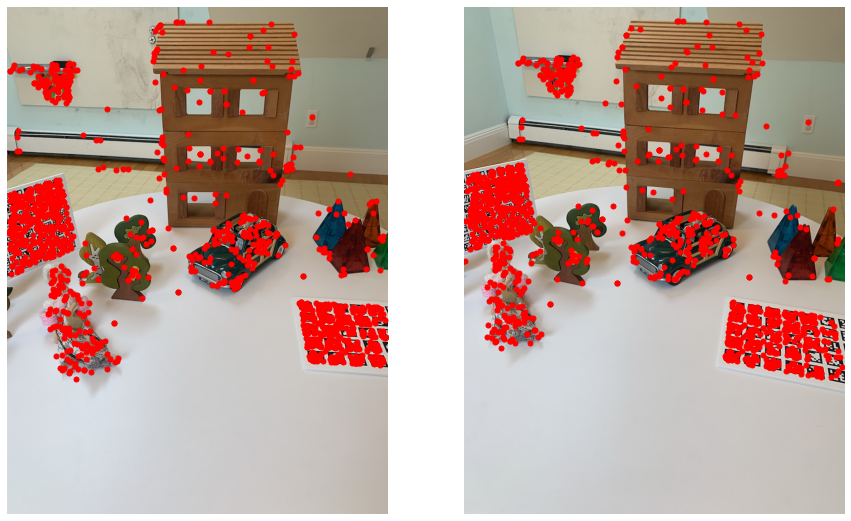

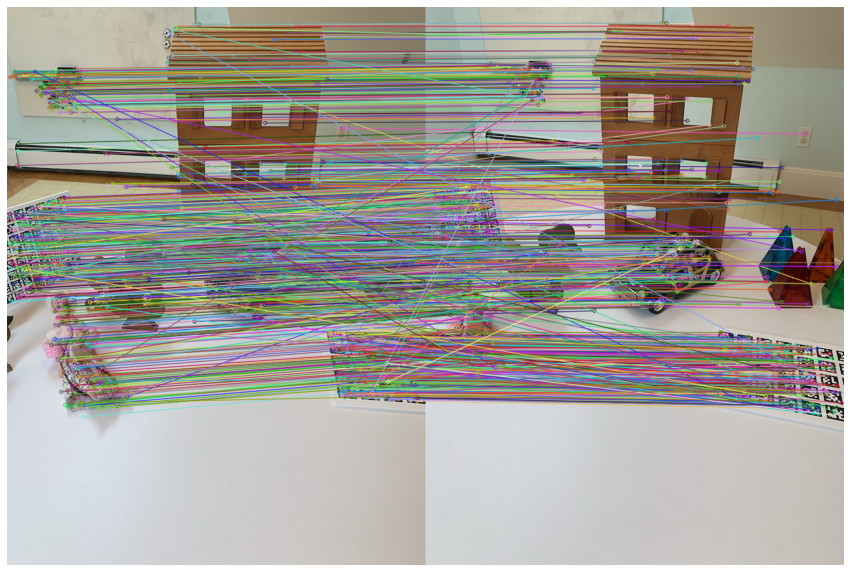

In [5]:
GOOD_MATCH_PERCENT=1   # top % of matches to keep between two images

# Create a SIFT object
sift = cv2.SIFT_create()

# Get SIFT keypoints and descriptors for each image
kp1, des1 = sift.detectAndCompute(cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY), None)
kp2, des2 = sift.detectAndCompute(cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY), None)

# Create a "brute force" matcher object using the L2 norm,
#  and using "cross check" to only keep symmetric matches
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Find matches between images 1->2 and images 3->2
# Notes:
#   - The output is a list of openCV "Dmatch" objects, which are described here:
#     https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
#   - Each entry of the output list represents a match between the input 
#     descriptor-sets and includes these three attributes 
#         matches12[i].distance - Distance between matched descriptors. The lower, the better it is.
#         matches12[i].queryIdx - Index of descriptor in first set (des1 or des3 here)
#         matches12[i].trainIdx - Index of descriptor in second set (des2 here)
#     (OpenCV's use of the names "train" and "query" here is particulary unintuitive.)
matches12 = bf.match(des1, des2)

# Sort matches in the order of increasing match-distance; keep top ones
matches12 = sorted(matches12, key = lambda x:x.distance)
numGoodMatches = int(len(matches12) * GOOD_MATCH_PERCENT)
matches12 = matches12[:numGoodMatches]

# Get pixel coordinates of the surving matches
X1 = np.array([kp1[match.queryIdx].pt for match in matches12])
X2 = np.array([kp2[match.trainIdx].pt for match in matches12])

# Plot points overlaid on images
_, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
ax1.imshow(im1)
ax1.plot(X1[:, 0], X1[:, 1], '.r', markersize=10)
ax1.axis('off')
ax2.imshow(im2)
ax2.plot(X2[:, 0], X2[:, 1], '.r', markersize=10)
ax2.axis('off')

# Draw matches
imMatches = cv2.drawMatches(im1,kp1,im2,kp2,matches12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.subplots(figsize=(15,15))
plt.imshow(imMatches)
plt.axis('off')
plt.show()


## Find fundamental matrix and good matches using RANSAC

OpenCV documentation: [cv2.findFundamentalMat()](https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga59b0d57f46f8677fb5904294a23d404a)


Number of matches that are good: 1026 of 1249
Fundamental Matrix:
 [[-1.98620172e-07 -2.00115692e-05 -1.54049147e-03]
 [ 8.22754890e-06 -3.13612075e-07  7.64197679e-02]
 [-7.96676673e-06 -7.06441652e-02  1.00000000e+00]]


(-0.5, 749.5, 999.5, -0.5)

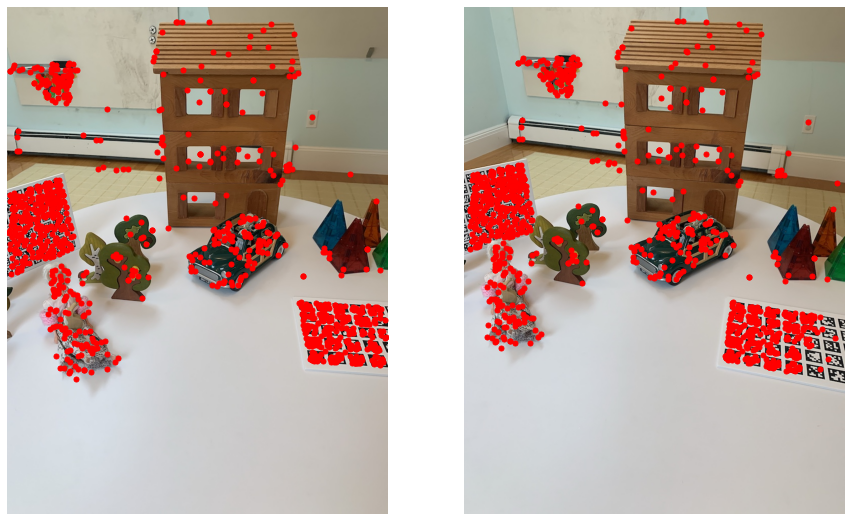

In [7]:
# compute fundamental matrix
F, mask = cv2.findFundamentalMat(X1,X2,cv2.FM_RANSAC) 

# mask : same size as X1 (2d array) tells which of the inputs are inliers(1) & outliers (0)

# Subset of points that are inliers
X1in = X1[mask.ravel()==1]
X2in = X2[mask.ravel()==1]

print('Number of matches that are good: {} of {}'.format(X1in.shape[0],X1.shape[0]))
print('Fundamental Matrix:\n', F)

# Plot points overlaid on images
_, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
ax1.imshow(im1)
ax1.plot(X1in[:, 0], X1in[:, 1], '.r', markersize=10)
ax1.axis('off')
ax2.imshow(im2)
ax2.plot(X2in[:, 0], X2in[:, 1], '.r', markersize=10)
ax2.axis('off')

# Question 1: Visualize epipolar lines 

Edit lines `12` and `13` to correctly compute the left and right epipolar lines that correspond to a pair of matching image points from corresponding rows in the $N\times 2$ array `X1in` and the $N\times 2$ array `X2in`.

Run the cell a few times for different choices of matching image points (by adjusting the integer index `ind`) and inspect the resulting plots to make sure your code is correct.

When you are satisfied with your code, post a snapshot of one of your results to [padlet](https://padlet.com/zickler/epipolar) including your name in the title of your post.

In [12]:
X1in.shape
X1hom = in2hom(X1in)
X2hom = in2hom(X2in)


print(X1hom.shape)

(1026, 3)


1

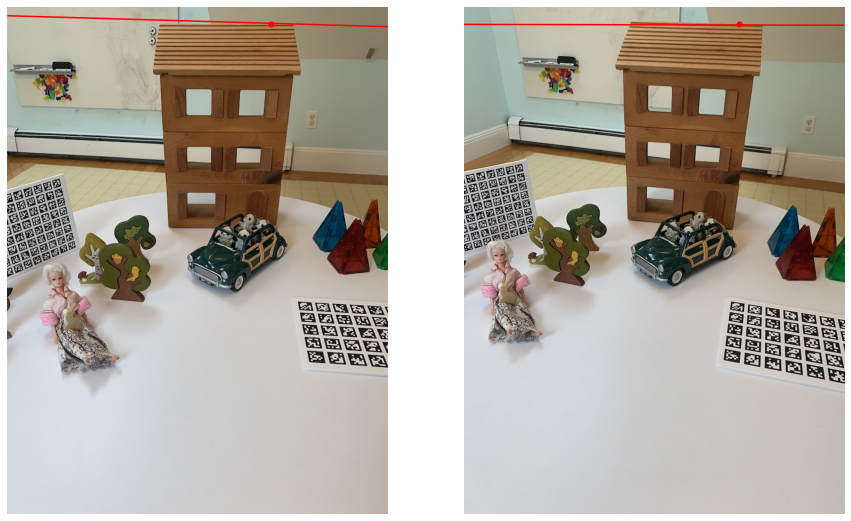

In [36]:
# Manually choose any integer between 0 and (Xin.shape[0]-1). This is the 
# row index in X1in and X2in of a pair of matching left and right image points.
ind = 3

# Retrieve image dimensions (for later use in plotting)
h,w,_=im2.shape

# Number of point matches
numMatches = X1in.shape[0]


X1_ind = X1hom[ind]
X2_ind = X2hom[ind]

# Edit the following two lines of code to compute epipolar lines L1=(a,b,c) and L2=(a',b',c')

# Recall: F is the matrix that transfers x1 to l'
L1= F @ X2_ind
L2= F.T @ X1_ind

# Plot points overlaid on images
_, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
ax1.imshow(im1)
ax1.plot(X1in[ind, 0], X1in[ind, 1], '.r', markersize=10)
ax1.axis('off')

ax2.imshow(im2)
ax2.plot(X2in[ind, 0], X2in[ind, 1], '.r', markersize=10)
ax2.axis('off')

# Plot corresponding epipolar lines
plotimageline(h,w,L1,ax1)
plotimageline(h,w,L2,ax2)

# Question 2: Visualize many epipolar lines 

It is helpful to draw the epipolar lines for multiple point-matches simultaneously. One way to do this is to compute the epipolar lines for _all_ $N$ points in `X1in` simultaneously using a matrix multiply operation that produces an $N\times 3$ array of right epipolar lines `L2`. An analogous operation performed on the $N$ right points `X2in` produces an $N\times 3$ array of left epipolar lines `L1`. 

Once this is done, you can immediately plot all of the corresponding points and lines, or any subset of them. (The skeleton code below plots a random subset of them.)

Edit lines `8` and `9` to correctly compute two $N\times 3$ arrays `L1` nd `L2`, where the $i$th row of `L1` is the left epipolar line $(a,b,c)$ corresponding to the right image point $(x',y')$ in $i$th row of `X2in`, and the $i$th row of `L2` is the right epipolar line $(a',b',c')$ corresponding to the left image point $(x,y)$ in $i$th row of `X1in`.

Run the cell a few times for different random subsets of plotted points and lines, and inspect the resulting plots to make sure your code is correct.

When you are satisfied with your code, post a snapshot of one of your results to [padlet](https://padlet.com/zickler/epipolar) including your name in the title of your post.

In [44]:
# Retrieve image dimensions (for later use in plotting)
h,w,_=im2.shape

# Number of point matches
numMatches = X1in.shape[0]

# Edit the following two lines of code to compute epipolar lines L1=(a,b,c) and L2=(a',b',c')
L1= (F.T @ X2hom.T).T
L2= (F @ X1hom.T).T

In [45]:
(F @ X1hom.T).T.shape

(1026, 3)

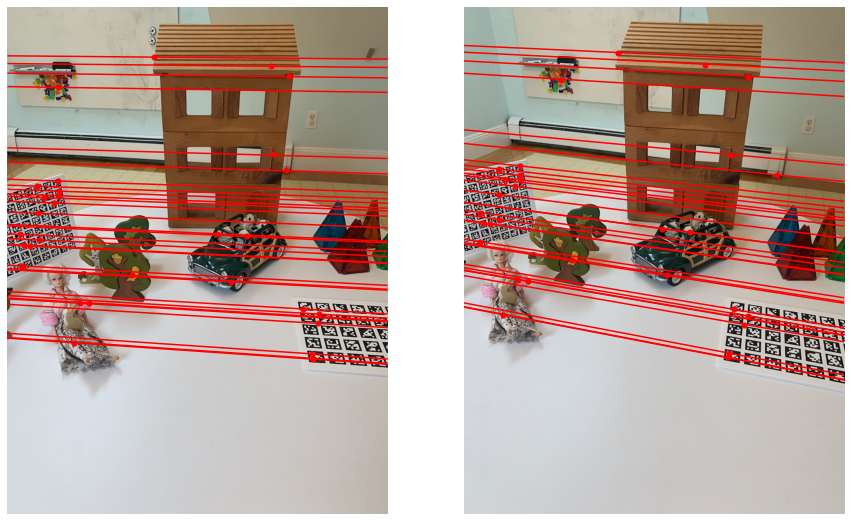

In [43]:
# Randomly choose NUMTOPLOT pooint-matches to visualize
NUMTOPLOT = 30
ind = np.random.choice(np.arange(X1in.shape[0]), 
                       size=NUMTOPLOT, 
                       replace=False)

# Plot points overlaid on images
_, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
ax1.imshow(im1)
ax1.plot(X1in[ind, 0], X1in[ind, 1], '.r', markersize=10)
ax1.axis('off')

ax2.imshow(im2)
ax2.plot(X2in[ind, 0], X2in[ind, 1], '.r', markersize=10)
ax2.axis('off')

# Plot corresponding epipolar lines
for i in ind:
    plotimageline(h,w,L1[i,:],ax1)
    plotimageline(h,w,L2[i,:],ax2)